# Adversarial Training

**Models**
- BERTurk
- BERT
- RoBERTa
- GPT-2
- XLNet
- Electra
- DistilBERT  

This notebook does AI-generated Text Detection with different NLP models. 

In [ ]:
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AdamW, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from transformers import BertForSequenceClassification, BertTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [2]:
# If you run the code on Google Colab
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/reviews_omitted15words.csv')
data

,review,label
0,oka üniversites hastane çalışa son zaman göste...,ai
1,ekiç kaşar peynir tam bir hayal kırıklık marke...,ai
2,similaç deva süt aldık iç tah çık bebek ür tük...,ai
3,ilha duma hukuk büro sürekli borç mesaj alıyor...,ai
4,samsungu marka kamera flaş ilgil yaşadık sor i...,ai
...,...,...
11595,xiaom telefon dokunmatik sor yıl aşk xiaom mi ...,human
11596,huawei matebook ekra parlaklık sor huawei d ma...,human
11597,mars athletiç clubmacfit kullanmadık şey iptal...,human
11598,show tv çukur dizis yay içerik bir ker izledi ...,human


In [4]:
# TextDataset sınıfı
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [5]:
# Adversarial training için PGD sınıfı
class PGD:
    def __init__(self, model, epsilon=0.01, alpha=0.3, num_steps=3):
        self.model = model
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_steps = num_steps
        self.backup = {}

    def attack(self, is_first_attack=False):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if is_first_attack:
                    self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0:
                    r_at = self.alpha * param.grad / norm
                    param.data.add_(r_at)
                    param.data = torch.clamp(param.data, self.backup[name] - self.epsilon, self.backup[name] + self.epsilon)

    def restore(self):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}

In [6]:
# Modify Trainer class to incorporate adversarial training
class AdversarialTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Normal forward pass
        outputs = model(**inputs)
        loss = outputs.loss

        # Adversarial training
        pgd.backup = {}
        pgd.attack(is_first_attack=True)
        outputs_adv = model(**inputs)
        loss_adv = outputs_adv.loss
        loss = (loss + loss_adv) / 2

        pgd.restore()
        return (loss, outputs) if return_outputs else loss

In [7]:
# Prepare the dataset for training
def is_valid_text(entry):
    return isinstance(entry, str)

# Assuming 'data' is a pandas DataFrame
valid_indices = [i for i, entry in enumerate(data['review']) if is_valid_text(entry)]
texts = [data['review'][i] for i in valid_indices]
labels = [data['label'][i] for i in valid_indices]

# Convert labels to numerical
labels = [1 if x == 'ai' else 0 for x in labels]

# Update the DataFrame with the filtered data
data = data.iloc[valid_indices].copy()  # Create a new DataFrame with the filtered rows
data['review'] = texts
data['label'] = labels


In [8]:
# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

### BERTurk

In [11]:
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased', num_labels=2)

# Prepare the data for BERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

pytorch_model.bin:  12%|#1        | 52.4M/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the PGD adversarial training
pgd = PGD(model)

# Initialize the Adversarial Trainer
trainer = AdversarialTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 110,618,882


Step,Training Loss,Validation Loss
100,0.477500,0.404415
200,0.094700,0.233164
300,0.057300,0.269625
400,0.069800,0.228508
500,0.266900,0.180540
600,0.019600,0.156270
700,0.230400,0.098422
800,0.278900,0.366601
900,0.100100,0.111305
1000,0.102700,0.159247



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model weights saved in ./results/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/model.safetensors


TrainOutput(global_step=1160, training_loss=0.21358740098517517, metrics={'train_runtime': 340.0133, 'train_samples_per_second': 27.29, 'train_steps_per_second': 3.412, 'total_flos': 476837398962000.0, 'train_loss': 0.21358740098517517, 'epoch': 1.0})

In [13]:
# Evaluate the model
berturk_results = trainer.evaluate()
print(berturk_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.10049279034137726, 'eval_runtime': 11.5598, 'eval_samples_per_second': 200.695, 'eval_steps_per_second': 12.543, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


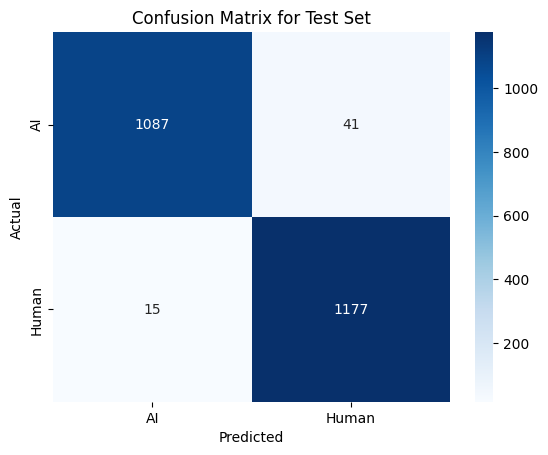

              precision    recall  f1-score   support

       Human       0.99      0.96      0.97      1128
          AI       0.97      0.99      0.98      1192

    accuracy                           0.98      2320
   macro avg       0.98      0.98      0.98      2320
weighted avg       0.98      0.98      0.98      2320



In [14]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [15]:
model_save_path = '/content/drive/MyDrive/test/berturk_adv_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/berturk_adv_model
Configuration saved in /content/drive/MyDrive/test/berturk_adv_model/config.json
Model weights saved in /content/drive/MyDrive/test/berturk_adv_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/berturk_adv_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/berturk_adv_model/special_tokens_map.json


('/content/drive/MyDrive/test/berturk_adv_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/berturk_adv_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/berturk_adv_model/vocab.txt',
 '/content/drive/MyDrive/test/berturk_adv_model/added_tokens.json')

### BERT

In [16]:
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Prepare the data for BERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the PGD adversarial training
pgd = PGD(model)

# Initialize the Adversarial Trainer
trainer = AdversarialTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.js

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mod

Step,Training Loss,Validation Loss
100,0.616600,0.573505
200,0.162200,0.271971
300,0.286300,0.254479
400,0.385600,0.197253
500,0.442600,0.255655
600,0.157000,0.209167
700,0.352000,0.292915
800,0.296400,0.297616
900,0.234300,0.160502
1000,0.408000,0.165369



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model weights saved in ./results/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/model.safetensors


TrainOutput(global_step=1160, training_loss=0.3211876315482218, metrics={'train_runtime': 559.6176, 'train_samples_per_second': 16.581, 'train_steps_per_second': 2.073, 'total_flos': 877380814090080.0, 'train_loss': 0.3211876315482218, 'epoch': 1.0})

In [17]:
# Evaluate the model
bert_results = trainer.evaluate()
print(bert_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.15728554129600525, 'eval_runtime': 21.6339, 'eval_samples_per_second': 107.239, 'eval_steps_per_second': 6.702, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


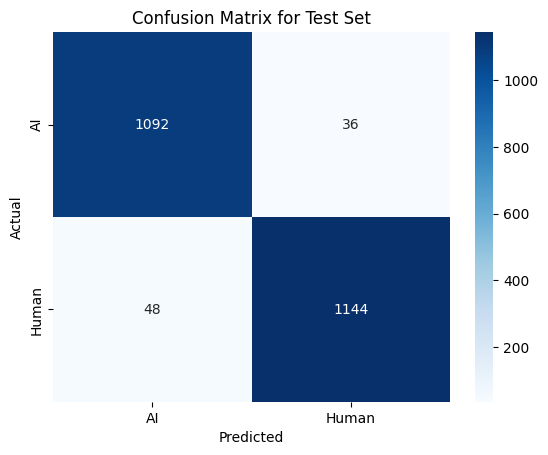

              precision    recall  f1-score   support

       Human       0.96      0.97      0.96      1128
          AI       0.97      0.96      0.96      1192

    accuracy                           0.96      2320
   macro avg       0.96      0.96      0.96      2320
weighted avg       0.96      0.96      0.96      2320



In [18]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [19]:
model_save_path = '/content/drive/MyDrive/test/bert_adv_model_last'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/bert_adv_model_last
Configuration saved in /content/drive/MyDrive/test/bert_adv_model_last/config.json
Model weights saved in /content/drive/MyDrive/test/bert_adv_model_last/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/bert_adv_model_last/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/bert_adv_model_last/special_tokens_map.json


('/content/drive/MyDrive/test/bert_adv_model_last/tokenizer_config.json',
 '/content/drive/MyDrive/test/bert_adv_model_last/special_tokens_map.json',
 '/content/drive/MyDrive/test/bert_adv_model_last/vocab.txt',
 '/content/drive/MyDrive/test/bert_adv_model_last/added_tokens.json')

### RoBERTa

In [ ]:
# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Tokenization
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaF

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results_roberta',  # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs_roberta',    # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the PGD adversarial training
pgd = PGD(model)

# Initialize the Adversarial Trainer
trainer = AdversarialTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 124,647,170


Step,Training Loss,Validation Loss
100,0.638400,0.593327
200,0.409300,0.689029
300,0.623000,0.370011
400,0.351400,0.376539
500,0.354600,0.295764
600,0.127400,0.259376
700,0.439600,0.296816
800,0.316300,0.394594
900,0.221100,0.196794
1000,0.215100,0.219179



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_roberta/checkpoint-100
Configuration saved in ./results_roberta/checkpoint-100/config.json
Model weights saved in ./results_roberta/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_roberta/checkpoint-200
Configuration saved in ./results_roberta/checkpoint-200/config.json
Model weights saved in ./results_roberta/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_roberta/checkpoint-300
Configuration saved in ./results_roberta/checkpoint-300/config.json
Model weights saved in ./results_roberta/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_roberta/checkpoint-400
Configuration saved in ./results_roberta/check

TrainOutput(global_step=1160, training_loss=0.36747092061258596, metrics={'train_runtime': 681.4477, 'train_samples_per_second': 13.617, 'train_steps_per_second': 1.702, 'total_flos': 991821789840960.0, 'train_loss': 0.36747092061258596, 'epoch': 1.0})

In [ ]:
# Evaluate the model
roberta_results = trainer.evaluate()
print(roberta_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.1973862498998642, 'eval_runtime': 27.4567, 'eval_samples_per_second': 84.497, 'eval_steps_per_second': 5.281, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


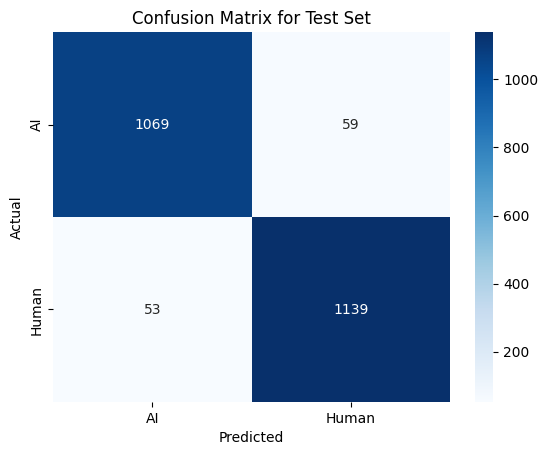

              precision    recall  f1-score   support

       Human       0.95      0.95      0.95      1128
          AI       0.95      0.96      0.95      1192

    accuracy                           0.95      2320
   macro avg       0.95      0.95      0.95      2320
weighted avg       0.95      0.95      0.95      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/roberta_adv_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/roberta_adv_model
Configuration saved in /content/drive/MyDrive/test/roberta_adv_model/config.json
Model weights saved in /content/drive/MyDrive/test/roberta_adv_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/roberta_adv_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/roberta_adv_model/special_tokens_map.json


('/content/drive/MyDrive/test/roberta_adv_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/roberta_adv_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/roberta_adv_model/vocab.json',
 '/content/drive/MyDrive/test/roberta_adv_model/merges.txt',
 '/content/drive/MyDrive/test/roberta_adv_model/added_tokens.json')

### GPT-2

In [ ]:
# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)

# Prepare the data for GPT-2
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

model.safetensors:  40%|####      | 220M/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results_gpt2',     # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the PGD adversarial training
pgd = PGD(model)

# Initialize the Adversarial Trainer
trainer = AdversarialTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 124,441,344


Step,Training Loss,Validation Loss
100,0.656400,0.580279
200,0.359200,0.445628
300,0.284200,0.231927
400,0.778800,1.051306
500,0.271700,0.488284
600,0.148500,0.222900
700,0.509900,0.262787
800,0.119300,0.236047
900,0.133500,0.171742
1000,0.245600,0.183987



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_gpt2/checkpoint-100
Configuration saved in ./results_gpt2/checkpoint-100/config.json
Model weights saved in ./results_gpt2/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_gpt2/checkpoint-200
Configuration saved in ./results_gpt2/checkpoint-200/config.json
Model weights saved in ./results_gpt2/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_gpt2/checkpoint-300
Configuration saved in ./results_gpt2/checkpoint-300/config.json
Model weights saved in ./results_gpt2/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_gpt2/checkpoint-400
Configuration saved in ./results_gpt2/checkpoint-400/config.json
Model weigh

TrainOutput(global_step=1160, training_loss=0.3835307608390677, metrics={'train_runtime': 754.5411, 'train_samples_per_second': 12.298, 'train_steps_per_second': 1.537, 'total_flos': 975511611408384.0, 'train_loss': 0.3835307608390677, 'epoch': 1.0})

In [ ]:
# Evaluate the model
gpt2_results = trainer.evaluate()
print(gpt2_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.18759825825691223, 'eval_runtime': 30.0833, 'eval_samples_per_second': 77.119, 'eval_steps_per_second': 4.82, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


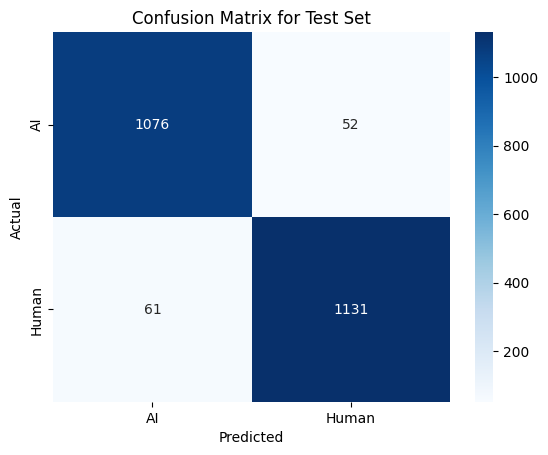

              precision    recall  f1-score   support

       Human       0.95      0.95      0.95      1128
          AI       0.96      0.95      0.95      1192

    accuracy                           0.95      2320
   macro avg       0.95      0.95      0.95      2320
weighted avg       0.95      0.95      0.95      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/gpt2_adv_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/gpt2_adv_model
Configuration saved in /content/drive/MyDrive/test/gpt2_adv_model/config.json
Model weights saved in /content/drive/MyDrive/test/gpt2_adv_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/gpt2_adv_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/gpt2_adv_model/special_tokens_map.json


('/content/drive/MyDrive/test/gpt2_adv_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/gpt2_adv_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/gpt2_adv_model/vocab.json',
 '/content/drive/MyDrive/test/gpt2_adv_model/merges.txt',
 '/content/drive/MyDrive/test/gpt2_adv_model/added_tokens.json')

### XLNet

In [ ]:
# Initialize the tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Prepare the data for XLNet
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results_xlnet',    # Output directory
    num_train_epochs=1,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs_xlnet',      # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',     # Evaluation strategy to adopt during training
    eval_steps=100,                  # Evaluation step to perform evaluation
    save_steps=100,                  # Save checkpoint every X steps
    log_level='info',                # Set logging level to info
    log_level_replica='info'         # Save checkpoint every X steps
)

# Initialize the PGD adversarial training
pgd = PGD(model)

# Initialize the Adversarial Trainer
trainer = AdversarialTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 117,310,466


Step,Training Loss,Validation Loss
100,0.645500,0.608877
200,0.327400,0.371235
300,0.396100,0.230036
400,0.472600,0.382208
500,0.305300,0.510251
600,0.162800,0.287900
700,0.468500,0.459368
800,0.334400,0.371716
900,0.227000,0.183115
1000,0.297400,0.154122



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_xlnet/checkpoint-100
Configuration saved in ./results_xlnet/checkpoint-100/config.json
Model weights saved in ./results_xlnet/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_xlnet/checkpoint-200
Configuration saved in ./results_xlnet/checkpoint-200/config.json
Model weights saved in ./results_xlnet/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_xlnet/checkpoint-300
Configuration saved in ./results_xlnet/checkpoint-300/config.json
Model weights saved in ./results_xlnet/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_xlnet/checkpoint-400
Configuration saved in ./results_xlnet/checkpoint-400/config.json


TrainOutput(global_step=1160, training_loss=0.36912976698628785, metrics={'train_runtime': 2417.1805, 'train_samples_per_second': 3.839, 'train_steps_per_second': 0.48, 'total_flos': 1197792489139488.0, 'train_loss': 0.36912976698628785, 'epoch': 1.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.17638389766216278, 'eval_runtime': 117.3616, 'eval_samples_per_second': 19.768, 'eval_steps_per_second': 1.235, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


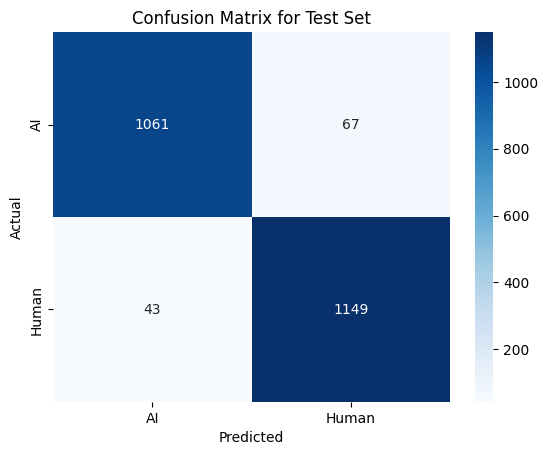

              precision    recall  f1-score   support

       Human       0.96      0.94      0.95      1128
          AI       0.94      0.96      0.95      1192

    accuracy                           0.95      2320
   macro avg       0.95      0.95      0.95      2320
weighted avg       0.95      0.95      0.95      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/xlnet_adv_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/xlnet_adv_model
Configuration saved in /content/drive/MyDrive/test/xlnet_adv_model/config.json
Model weights saved in /content/drive/MyDrive/test/xlnet_adv_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/xlnet_adv_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/xlnet_adv_model/special_tokens_map.json


('/content/drive/MyDrive/test/xlnet_adv_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/xlnet_adv_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/xlnet_adv_model/spiece.model',
 '/content/drive/MyDrive/test/xlnet_adv_model/added_tokens.json')

### Electra

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results_electra',    # Output directory
    num_train_epochs=1,                # Number of training epochs
    per_device_train_batch_size=8,     # Batch size for training
    per_device_eval_batch_size=16,     # Batch size for evaluation
    warmup_steps=500,                  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Strength of weight decay
    logging_dir='./logs_electra',      # Directory for storing logs
    logging_steps=10,                  # Log every X steps
    evaluation_strategy='steps',       # Evaluation strategy to adopt during training
    eval_steps=100,                    # Evaluation step to perform evaluation
    save_steps=100,                    # Save checkpoint every X steps
    log_level='info',                  # Set logging level to info
)

# Initialize the PGD adversarial training
pgd = PGD(model)

# Initialize the Adversarial Trainer
trainer = AdversarialTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 13,549,314


Step,Training Loss,Validation Loss
100,0.685000,0.690275
200,0.486200,0.491002
300,0.379500,0.371542
400,0.463500,0.779761
500,0.360100,0.307301
600,0.201300,0.208842
700,0.427400,0.222827
800,0.214800,0.230876
900,0.123600,0.254500
1000,0.244000,0.210841



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_electra/checkpoint-100
Configuration saved in ./results_electra/checkpoint-100/config.json
Model weights saved in ./results_electra/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_electra/checkpoint-200
Configuration saved in ./results_electra/checkpoint-200/config.json
Model weights saved in ./results_electra/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_electra/checkpoint-300
Configuration saved in ./results_electra/checkpoint-300/config.json
Model weights saved in ./results_electra/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_electra/checkpoint-400
Configuration saved in ./results_electra/check

TrainOutput(global_step=1160, training_loss=0.350669861944585, metrics={'train_runtime': 138.0335, 'train_samples_per_second': 67.223, 'train_steps_per_second': 8.404, 'total_flos': 98103929491296.0, 'train_loss': 0.350669861944585, 'epoch': 1.0})

In [ ]:
# Evaluate the model
electra_results = trainer.evaluate()
print(electra_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.2127881646156311, 'eval_runtime': 3.9315, 'eval_samples_per_second': 590.113, 'eval_steps_per_second': 36.882, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


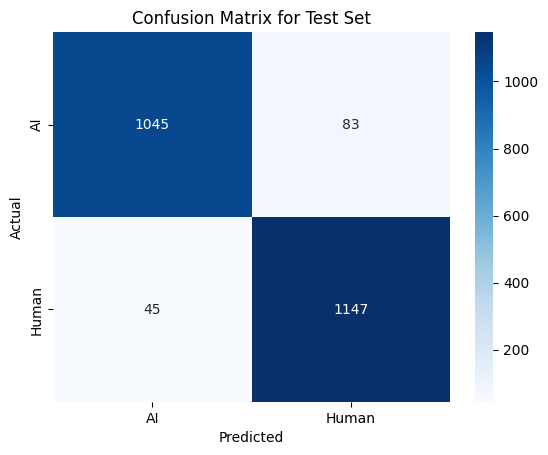

              precision    recall  f1-score   support

       Human       0.96      0.93      0.94      1128
          AI       0.93      0.96      0.95      1192

    accuracy                           0.94      2320
   macro avg       0.95      0.94      0.94      2320
weighted avg       0.95      0.94      0.94      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/electra_adv_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/electra_adv_model
Configuration saved in /content/drive/MyDrive/test/electra_adv_model/config.json
Model weights saved in /content/drive/MyDrive/test/electra_adv_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/electra_adv_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/electra_adv_model/special_tokens_map.json


('/content/drive/MyDrive/test/electra_adv_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/electra_adv_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/electra_adv_model/vocab.txt',
 '/content/drive/MyDrive/test/electra_adv_model/added_tokens.json')

### DistilBERT

In [ ]:
# Initialize the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Prepare the data for DistilBERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.42.4",
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBer

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification 

In [ ]:
# Set training arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',    # Output directory
    num_train_epochs=1,                   # Number of training epochs
    per_device_train_batch_size=8,        # Batch size for training
    per_device_eval_batch_size=16,        # Batch size for evaluation
    warmup_steps=500,                     # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                    # Strength of weight decay
    logging_dir='./logs_distilbert',      # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',          # Evaluation strategy to adopt during training
    eval_steps=100,                       # Evaluation step to perform evaluation
    save_steps=100,                       # Save checkpoint every X steps
    log_level='info',                     # Set logging level to info
    log_level_replica='info'              # Save checkpoint every X steps
)

# Initialize the PGD adversarial training
pgd = PGD(model)

# Initialize the Adversarial Trainer
trainer = AdversarialTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 9,279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,160
  Number of trainable parameters = 66,955,010


Step,Training Loss,Validation Loss
100,0.626300,0.613612
200,0.233600,0.364689
300,0.496300,0.310420
400,0.393500,0.182337
500,0.381600,0.201920
600,0.385800,0.183260
700,0.279000,0.195971
800,0.207400,0.306816
900,0.190800,0.154374
1000,0.221600,0.152770



***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_distilbert/checkpoint-100
Configuration saved in ./results_distilbert/checkpoint-100/config.json
Model weights saved in ./results_distilbert/checkpoint-100/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_distilbert/checkpoint-200
Configuration saved in ./results_distilbert/checkpoint-200/config.json
Model weights saved in ./results_distilbert/checkpoint-200/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_distilbert/checkpoint-300
Configuration saved in ./results_distilbert/checkpoint-300/config.json
Model weights saved in ./results_distilbert/checkpoint-300/model.safetensors

***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16
Saving model checkpoint to ./results_distilbert/checkpoint-400
Configuration sa

TrainOutput(global_step=1160, training_loss=0.3089567701107469, metrics={'train_runtime': 310.8567, 'train_samples_per_second': 29.85, 'train_steps_per_second': 3.732, 'total_flos': 441731169046368.0, 'train_loss': 0.3089567701107469, 'epoch': 1.0})

In [ ]:
# Evaluate the model
d_bert_results = trainer.evaluate()
print(d_bert_results)


***** Running Evaluation *****
  Num examples = 2320
  Batch size = 16


{'eval_loss': 0.15823037922382355, 'eval_runtime': 12.3645, 'eval_samples_per_second': 187.634, 'eval_steps_per_second': 11.727, 'epoch': 1.0}



***** Running Prediction *****
  Num examples = 2320
  Batch size = 16


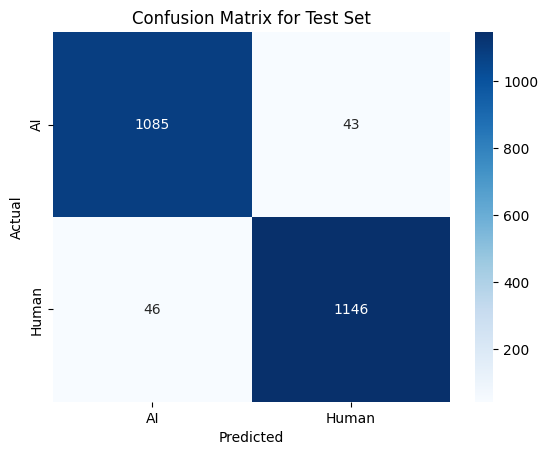

              precision    recall  f1-score   support

       Human       0.96      0.96      0.96      1128
          AI       0.96      0.96      0.96      1192

    accuracy                           0.96      2320
   macro avg       0.96      0.96      0.96      2320
weighted avg       0.96      0.96      0.96      2320



In [ ]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions
pred_labels = np.argmax(preds, axis=1)  # Get the predicted labels

# If you need the true labels
true_labels = [example['labels'] for example in test_dataset]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=['Human', 'AI'])
print(report)

In [ ]:
model_save_path = '/content/drive/MyDrive/test/d_bert_adv_model'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to /content/drive/MyDrive/test/d_bert_adv_model
Configuration saved in /content/drive/MyDrive/test/d_bert_adv_model/config.json
Model weights saved in /content/drive/MyDrive/test/d_bert_adv_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/test/d_bert_adv_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/test/d_bert_adv_model/special_tokens_map.json


('/content/drive/MyDrive/test/d_bert_adv_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/d_bert_adv_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/d_bert_adv_model/vocab.txt',
 '/content/drive/MyDrive/test/d_bert_adv_model/added_tokens.json')